# DEFINICIÓN DE PARÁMETROS

In [1]:
#######################################################################################################################

# Ruta hacia los CSV del dataset
train_file_relative = './data/700Train.csv'
validation_file_relative = './data/700Validation.csv'
test_file_relative = './data/700Test.csv'

# Ruta al directorio de imágenes con máscara aplicada
masked_dir_relative = '../local/output_masked'
edited_dir_relative = '../local/output_edited'

model_dir_relative = "./models"

# Ruta relativa hacia la librería ai4eutils
ai4eutils_relative = "./repos/ai4eutils"

# Ruta relativa hacia la librería CameraTraps
CameraTraps_relative = "./repos/CameraTraps"

#######################################################################################################################

# DEFINICIÓN PARÁMETROS CNN

In [2]:
#######################################################################################################################

EPOCHS = 50
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

IMG_HEIGHT = IMG_WIDTH = 448

#######################################################################################################################

In [3]:
import os
import platform

import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

from modules.dataset_utils import DatasetUtils

home = os.path.expanduser("~")

ai4utils = os.path.abspath(ai4eutils_relative)
CameraTraps = os.path.abspath(CameraTraps_relative)
train_file = os.path.abspath(train_file_relative)
validation_file = os.path.abspath(validation_file_relative)
test_file = os.path.abspath(test_file_relative)
masked_dir = os.path.abspath(masked_dir_relative)
edited_dir = os.path.abspath(edited_dir_relative)
model_dir = os.path.abspath(model_dir_relative)

try:
    os.environ['PYTHONPATH']
except KeyError:
    os.environ['PYTHONPATH'] = ""
if platform.system() == 'Windows':
    os.environ['PYTHONPATH'] += (";" + ai4utils)
    os.environ['PYTHONPATH'] += (";" + CameraTraps)
else:
    os.environ['PYTHONPATH'] += (":" + ai4utils)
    os.environ['PYTHONPATH'] += (":" + CameraTraps)

print('==============================================================================================================')
print('PYTHONPATH: ' + os.environ['PYTHONPATH'])
print('')
print('ai4eutils PATH: ' + '\t\t' + ai4utils)
print('CameraTraps PATH: ' + '\t\t' + CameraTraps)
print('Train CSV PATH: ' + '\t\t' + train_file)
print('Validation CSV PATH: ' + '\t' + validation_file)
print('Test CSV PATH: ' + '\t\t\t' + test_file)
print('masked PATH: ' + '\t\t\t' + masked_dir)
print('edited PATH: ' + '\t\t\t' + edited_dir)
print('models PATH: ' + '\t\t\t' + model_dir)
print('==============================================================================================================')


TensorFlow version: 2.10.0
Is GPU available? tf.test.is_gpu_available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PYTHONPATH: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps

ai4eutils PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils
CameraTraps PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps
Train CSV PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Train.csv
Validation CSV PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Validation.csv
Test CSV PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Test.csv
masked PATH: 			/Users/carlos/WORKSPACE/local/output_masked
edited PATH: 			/Users/carlos/WORKSPACE/local/output_edited
models PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models


# Generate Datasets

In [4]:
custom = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
)

general = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

file_names, labels = DatasetUtils.load_dataset(train_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
train_df = pd.DataFrame(data=d, dtype=str)
train_dataset = custom.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

file_names, labels = DatasetUtils.load_dataset(validation_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
validation_df = pd.DataFrame(data=d, dtype=str)
validation_dataset = general.flow_from_dataframe(
    dataframe=validation_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

file_names, labels = DatasetUtils.load_dataset(test_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
test_df = pd.DataFrame(data=d, dtype=str)
test_dataset = general.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 1450 validated image filenames belonging to 2 classes.
Found 312 validated image filenames belonging to 2 classes.
Found 311 validated image filenames belonging to 2 classes.


# Custom CNN Architecture

In [5]:
model = keras.Sequential([
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    # Full connected
    keras.layers.Flatten(),
    keras.layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(LEARNING_RATE), activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(LEARNING_RATE), activation=tf.nn.relu),
    keras.layers.Dropout(0.3),

    # Capa de salida
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[keras.losses.BinaryCrossentropy()],
    metrics=['accuracy'])

Metal device set to: Apple M1


2022-10-18 12:51:54.087886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-18 12:51:54.087979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 448, 448, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                        

Epoch 1/50


2022-10-18 12:51:54.682428: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 12:51:55.183163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 0.7710 - accuracy: 0.8591

2022-10-18 12:52:26.715702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 34s 309ms/step - loss: 0.7710 - accuracy: 0.8591 - val_loss: 0.9896 - val_accuracy: 0.3651
Epoch 2/50
90/90 [==============================] - 25s 275ms/step - loss: 0.6192 - accuracy: 0.8856 - val_loss: 0.9675 - val_accuracy: 0.6579
Epoch 3/50
90/90 [==============================] - 25s 278ms/step - loss: 0.5625 - accuracy: 0.8982 - val_loss: 1.1436 - val_accuracy: 0.6349
Epoch 4/50
90/90 [==============================] - 25s 278ms/step - loss: 0.5045 - accuracy: 0.9191 - val_loss: 1.2151 - val_accuracy: 0.6217
Epoch 5/50
90/90 [==============================] - 25s 277ms/step - loss: 0.4733 - accuracy: 0.9261 - val_loss: 1.2516 - val_accuracy: 0.6414
Epoch 6/50
90/90 [==============================] - 25s 275ms/step - loss: 0.4602 - accuracy: 0.9240 - val_loss: 0.7194 - val_accuracy: 0.6711
Epoch 7/50
90/90 [==============================] - 25s 274ms/step - loss: 0.4415 - accuracy: 0.9358 - val_loss: 0.6918 - val_accuracy: 0.6513
Epoch 8/50

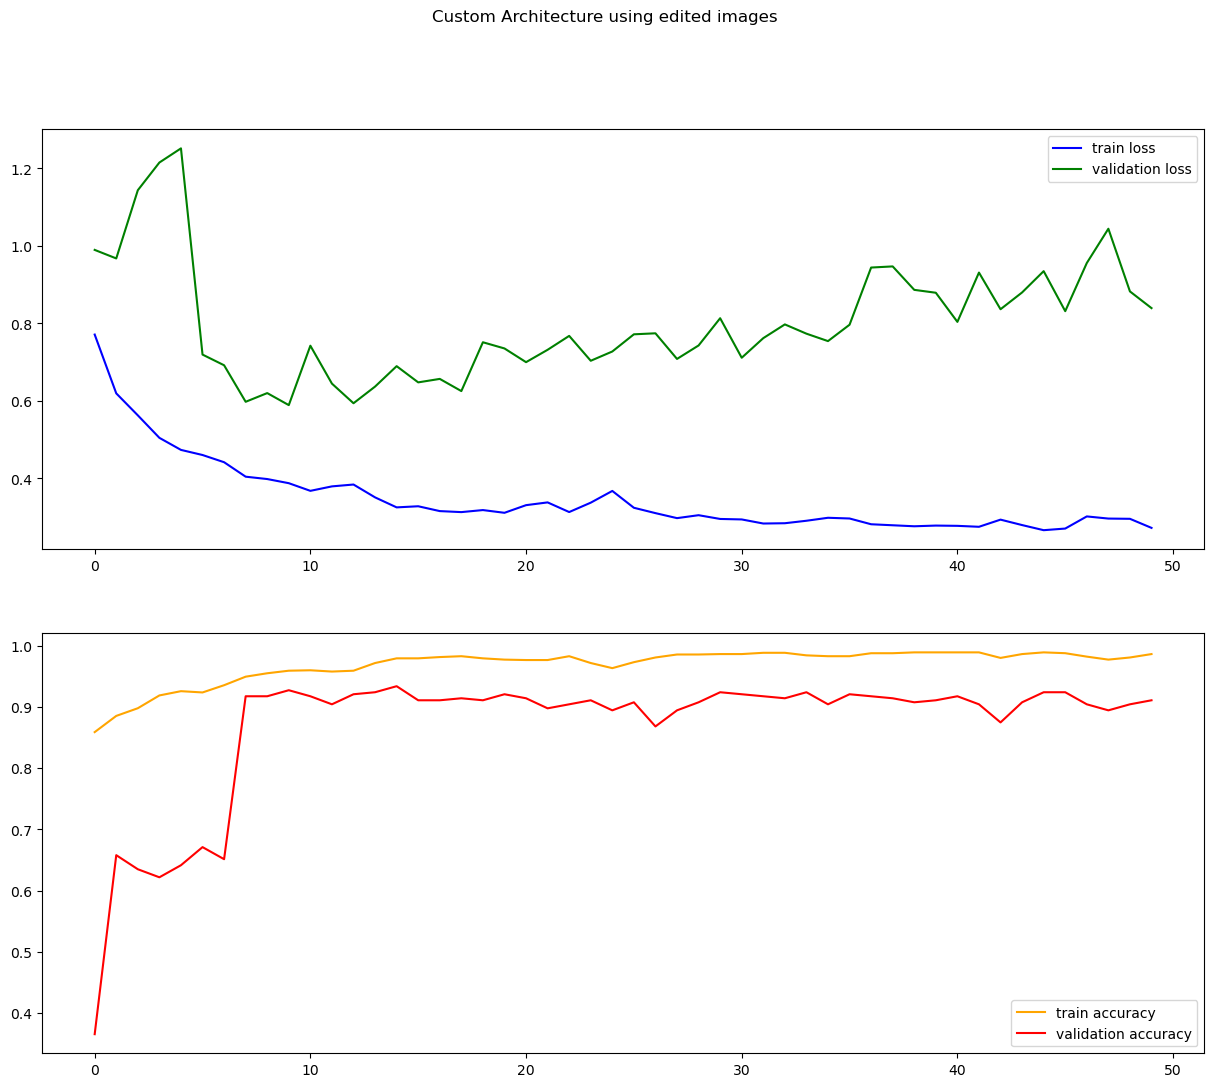

In [6]:
hist = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // BATCH_SIZE,
    verbose=1
)
results = model.evaluate(
    test_dataset,
    batch_size=BATCH_SIZE,
    verbose=1
)

fig = plt.figure(figsize=(15, 12))
fig.suptitle('Custom Architecture using edited images')

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(hist.history['loss'], color='blue', label='train loss', )
ax1.plot(hist.history['val_loss'], color='green', label='validation loss')
ax1.legend(loc="upper right")
ax2.plot(hist.history['accuracy'], color='orange', label='train accuracy')
ax2.plot(hist.history['val_accuracy'], color='red', label='validation accuracy')
ax2.legend(loc="lower right")
plt.show()